In [46]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import date


from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
## Setting plotting styles and context
sns.set(font_scale = 1)
sns.set(rc={"figure.dpi":100})

sns.set_style('whitegrid')
sns.set_context('notebook')

sns.set_palette("deep")

In [4]:
modeling_data = pd.read_csv("Kmeans_Labeled_Customer_Data.csv")

In [5]:
modeling_data.shape

(2206, 30)

# Classification


### Checking correlations

In [14]:
pd.set_option("display.max_columns", None)

def _color_red_or_green(val):
    color = 'red' if val < -0.6 else 'black'
    color = 'green' if val > 0.6 else color
    return 'color: %s' % color

modeling_data.corr().style.applymap(_color_red_or_green)

,ID,Relationship_Status,Income,Children,Kidhome,Teenhome,Enroll_Age,Wines,Fruits,Meat,Fish,Sweets,Gold,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Response,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumDealsPurchases,NumWebVisitsMonth,Age,Family_Size,CampAccepted,Education,spend_per_unit_income,labels
ID,1.000000,0.019864,0.000290,-0.001268,0.001412,-0.003139,0.005361,-0.019631,0.009701,-0.003731,-0.022914,-0.004489,-0.008646,-0.019163,-0.014859,-0.035572,-0.023577,-0.006213,-0.023985,-0.017537,-0.001373,-0.011724,-0.040457,-0.008130,-0.005122,0.009440,-0.034613,-0.007692,-0.009200,-0.032583
Relationship_Status,0.019864,1.000000,-0.004520,0.041079,0.024734,0.032142,-0.009134,-0.009533,-0.027238,-0.025813,-0.016564,-0.017650,-0.023951,0.010822,-0.003326,-0.019725,-0.007546,0.018878,-0.149034,0.002900,-0.010892,0.003663,0.026861,0.002930,0.003364,0.562065,0.000007,0.006291,-0.001016,-0.930589
Income,0.000290,-0.004520,1.000000,-0.342300,-0.514377,0.036372,-0.026953,0.687753,0.506868,0.692107,0.520041,0.524777,0.388138,0.327117,0.104356,-0.014733,0.220382,0.393279,0.161289,0.459606,0.695795,0.632300,-0.106969,-0.649718,0.199838,-0.285740,0.364850,0.128850,0.253250,0.040467
Children,-0.001268,0.041079,-0.342300,1.000000,0.687878,0.697832,-0.031119,-0.353026,-0.394706,-0.504198,-0.426711,-0.390576,-0.266566,-0.229646,-0.070402,-0.020179,-0.089197,-0.282914,-0.168059,-0.149209,-0.442225,-0.324552,0.435971,0.414305,0.095395,0.849484,-0.244694,0.049114,-0.219919,-0.061829
Kidhome,0.001412,0.024734,-0.514377,0.687878,1.000000,-0.039858,-0.052533,-0.497615,-0.373551,-0.439618,-0.389087,-0.379286,-0.355109,-0.174073,-0.082251,0.015520,-0.162912,-0.203716,-0.077037,-0.372101,-0.505156,-0.502481,0.217313,0.447709,-0.237484,0.582481,-0.211261,-0.037825,-0.242802,-0.043686
Teenhome,-0.003139,0.032142,0.036372,0.697832,-0.039858,1.000000,0.009001,0.005066,-0.174742,-0.260278,-0.203471,-0.163398,-0.016537,-0.144362,-0.015752,-0.043095,0.037972,-0.188441,-0.155336,0.161789,-0.110288,0.049066,0.385728,0.128542,0.365680,0.594633,-0.128380,0.104939,-0.063149,-0.042006
Enroll_Age,0.005361,-0.009134,-0.026953,-0.031119,-0.052533,0.009001,1.000000,0.154695,0.054988,0.080289,0.068045,0.073471,0.143540,-0.040316,-0.000740,-0.010799,0.009475,-0.024009,0.169663,0.167940,0.085508,0.096879,0.184532,0.253238,-0.021740,-0.030583,-0.024291,-0.040702,0.106264,0.008103
Wines,-0.019631,-0.009533,0.687753,-0.353026,-0.497615,0.005066,0.154695,1.000000,0.386177,0.567244,0.398550,0.391120,0.393906,0.352942,0.206882,0.061853,0.374511,0.471038,0.247344,0.553690,0.633673,0.641721,0.010713,-0.320949,0.163548,-0.297266,0.510291,0.163565,0.379600,0.061913
Fruits,0.009701,-0.027238,0.506868,-0.394706,-0.373551,-0.174742,0.054988,0.386177,1.000000,0.547173,0.591841,0.571793,0.391286,0.189976,-0.009858,0.014856,0.006799,0.206662,0.122120,0.303430,0.484369,0.460115,-0.133386,-0.416226,0.014956,-0.341118,0.153798,-0.087068,0.251001,0.051516
Meat,-0.003731,-0.025813,0.692107,-0.504198,-0.439618,-0.260278,0.080289,0.567244,0.547173,1.000000,0.574237,0.536829,0.359048,0.315688,0.043748,0.018711,0.092135,0.374541,0.240397,0.307204,0.734130,0.487546,-0.120077,-0.538704,0.030940,-0.431002,0.306603,0.005546,0.471240,0.064087


Correlated with 
1. Income : positively with wines, meat, catalog and store purchases; negatively with web visits per month
2.

Will start with a simple hypothesis to avoid overfitting. If the model underfits, we will replace the aggregate variables with their individual components to remove bias and use regularization to make sure the model doesn't overfits.

In [32]:
# 'Kidhome', 'Teenhome', 
# 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5'

# c_to_drop = ['ID','CampAccepted', 'Family_Size', 'Children']
c_to_drop = ['ID','Kidhome', 'Teenhome', 'Family_Size', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4','AcceptedCmp5','labels']
c_temp = modeling_data.drop(c_to_drop, axis = 1)


In [33]:
c_temp.shape

(2206, 20)

In [34]:
c_temp.columns

Index(['Relationship_Status', 'Income', 'Children', 'Enroll_Age', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Response',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumDealsPurchases', 'NumWebVisitsMonth', 'Age', 'CampAccepted',
       'Education', 'spend_per_unit_income'],
      dtype='object')

## Data with selected features

In [35]:
c_X = c_temp.drop('Response', axis = 1)
c_y = c_temp['Response']

## Train and test split of data

In [36]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(c_X.values, c_y, test_size = 0.2, stratify = c_y)


In [37]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1764, 19)
(442, 19)
(1764,)
(442,)


In [38]:
print("Training Target Class Distribution:")
print(pd.Series(y_train).value_counts().sort_values(),"\n\n")

print("Test Target Class Distribution:")
print(pd.Series(y_test).value_counts().sort_values())


Training Target Class Distribution:
1     265
0    1499
Name: Response, dtype: int64 


Test Target Class Distribution:
1     66
0    376
Name: Response, dtype: int64


In [39]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1764, 19)
(442, 19)
(1764,)
(442,)


In [40]:
# from imblearn.over_sampling import SMOTE 
# from imblearn.under_sampling import RandomUnderSampler
# os = SMOTE(sampling_strategy = {1:1000} , random_state=42)
# X_train, y_train = os.fit_resample(X_train, y_train)
# pd.Series(y_train).value_counts()

/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

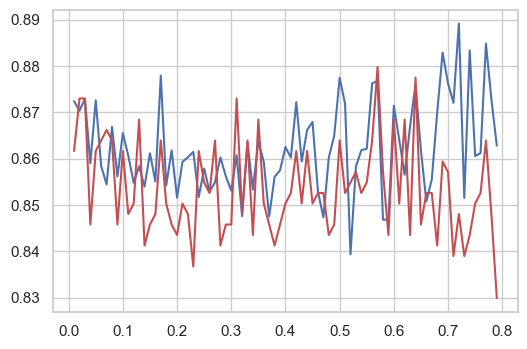

In [43]:


cv_score = []
tr_score = []

X_t, X_cv, y_t, y_cv  = train_test_split(X_train, y_train, test_size = 0.25, stratify = y_train)

sc = MinMaxScaler(feature_range=(-3,3))
X_s = sc.fit_transform(X_t)
X_cv_s = sc.transform(X_cv)


for i in range(10,800,10):
    logreg = LogisticRegression(max_iter=2000)
    train_perc = i/1000
    X_temp, _, y_temp, _  = train_test_split(X_t, y_t, test_size = train_perc, stratify = y_t)
    
    logreg.fit(X_temp, y_temp)
    
    tr_score.append(logreg.score(X_temp, y_temp))
    cv_score.append(logreg.score(X_cv, y_cv))

plt.plot(np.asarray([*range(10,800,10)])/1000, tr_score, c = 'b')
plt.plot(np.asarray([*range(10,800,10)])/1000, cv_score, c = 'r')






### Grid search for best model

In [48]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Setting up the pipleline steps and initializing the grid search object
c_scaler = MinMaxScaler(feature_range=(-1,1))

# Initializing the estimator
# clf = LogisticRegression(penalty='l2')
clf = RandomForestClassifier(random_state=21)
# clf = SVC(random_state=21)

steps = [('Scale', c_scaler),('Clf', clf)]
pipeline = Pipeline(steps)

In [49]:
# # Logistic Parameters for GridSearchCV

# param_grid = { 
#     'Clf__C': np.arange(0.1,1,0.1)
# }

# SVM Parameters for GridSearchCV

# param_grid = { 
#     'Clf__kernel': ['rbf'],
# #     'Clf__max_iter':[1000,2000,3000],
#     'Clf__gamma' : np.arange(0.1,1,0.1)    
# }


# Random Forest Parameters for GridSearchCV

param_grid = { 
    'Clf__n_estimators': [100, 200, 300],
    'Clf__max_features': ['sqrt', 'log2', 'auto'],
    'Clf__max_depth' : [None,2,4,6],
    'Clf__criterion' :['gini','logloss'],
    'Clf__min_samples_split':[2,3,4]
}

# parameters = {'Clf__C': np.arange(0.1, 3,0.1)} ## key  = step name + "__" parameter name

In [50]:
cv = GridSearchCV(pipeline, param_grid=param_grid, cv=4, scoring='f1')

In [51]:
# Fitting the GridSearchCV object and predicting the class labels for both train and test set.
cv.fit(X_train, y_train)
y_tpred = cv.predict(X_train)
y_pred = cv.predict(X_test)

/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
432 fits failed out of a total of 864.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/harshbaberwal/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.

In [ ]:
cv.best_estimator_.get_params

In [52]:

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(cv.best_params_)

print("Training F1 Score: ", round(cv.score(X_train, y_train),2))
print("Testing F1 Score: ", round(cv.score(X_test, y_test),2))

print("\n")

print("Training Accuracy Score: ", round(cv.best_estimator_.score(X_train, y_train)*100,2))
print("Testing Accuracy Score: ", round(cv.best_estimator_.score(X_test, y_test)*100,2))

print("\n")

print("Training Data Confusion Matrix")
print(confusion_matrix(y_train, y_tpred))

print("\n")

print("Testing Data Confusion Matrix")
print(confusion_matrix(y_test, y_pred))

print("\n")

print("Testing Data Classification Report")
print(classification_report(y_test, y_pred))

{'Clf__criterion': 'gini', 'Clf__max_depth': None, 'Clf__max_features': 'sqrt', 'Clf__min_samples_split': 3, 'Clf__n_estimators': 100}
Training F1 Score:  0.98
Testing F1 Score:  0.34


Training Accuracy Score:  99.38
Testing Accuracy Score:  85.07


Training Data Confusion Matrix
[[1495    4]
 [   7  258]]


Testing Data Confusion Matrix
[[359  17]
 [ 49  17]]


Testing Data Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.92       376
           1       0.50      0.26      0.34        66

    accuracy                           0.85       442
   macro avg       0.69      0.61      0.63       442
weighted avg       0.82      0.85      0.83       442



In [53]:
cv.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(steps=[('Scale', MinMaxScaler(feature_range=(-1, 1))),
                ('Clf',
                 RandomForestClassifier(max_features='sqrt',
                                        min_samples_split=3,
                                        random_state=21))])>

In [54]:
PrecisionRecallDisplay.from_estimator(cv, X_test, y_test)

NameError: name 'PrecisionRecallDisplay' is not defined

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=21, max_depth=4)
rf_model.fit(X_train_scaled, y_train)
y_tpred = rf_model.predict(X_train_scaled)
y_pred = rf_model.predict(X_test_scaled)

print("Training accuracy is {}".format(round(rf_model.score(X_train_scaled, y_train),3)))
print("Testing accuracy is {}".format(round(rf_model.score(X_test_scaled, y_test),3)))
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(rf_model, X_test, y_test)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Training Data Metrics")
print(confusion_matrix(y_train, y_tpred))
print(classification_report(y_train, y_tpred))

# print(confusion_matrix(y_train, y_pred))
# print(classification_report(y_train, y_pred))


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Testing Data Metrics")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))



In [ ]:
modeling_data.Response.value_counts()